# Técnicas de Prendizaje Automático. Aprendizaje por Refuerzo

## Práctica 2: SARSA

En esta práctica se utilizará [Gymnasium](https://gymnasium.farama.org/index.html) para entrenar un agente que aprenderá a jugar [Blackjack](https://es.wikipedia.org/wiki/Blackjack) utilizando el algoritmo SARSA.

**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.
<br></br>
- incluya el código requerido entre los apartados:
   - \#\<code>
   - \#\</code>

### Dependencias y utilidades
Ejecute las dos casillas siguientes para instalar algunas dependencias y definir funciones necesarias.

In [76]:
%%capture
!pip install -q swig
!pip install gymnasium[all]

!pip install --upgrade ipykernel

In [77]:
##@title Utilidades
##@markdown Ejecute esta casilla para definir algunas funciones necesarias en la actividad.

import gymnasium as gym
import plotly.express as px
import numpy as np
#from google.colab import output
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

def visualize_trace(x, y):
  """
  visualiza el promedio de episodios ganados
  """

  ne = np.ones(x.shape[0]) #
  ne = np.cumsum(ne)

  yt = y == 1 # 1 retorno al ganar
  yt = np.cumsum(yt) / ne

  fig = px.line(x=x, y=yt, labels={'x':'Episodio', 'y':'Ganados'})


  fig.update_layout(height=300,
                    width=1200,
                    yaxis_range=[0,1],
                    showlegend=False
                    )
  return fig


def create_grids(agent, usable_ace=False):

  state_value = defaultdict(float)
  policy = defaultdict(int)
  for obs, action_values in agent.q_values.items():
      state_value[obs] = float(np.max(action_values))
      policy[obs] = int(np.argmax(action_values))

  player_count, dealer_count = np.meshgrid(
      np.arange(12, 22),
      np.arange(1, 11),
  )

  value = np.apply_along_axis(
      lambda obs: state_value[(obs[0], obs[1], usable_ace)],
      axis=2,
      arr=np.dstack([player_count, dealer_count]),
  )
  value_grid = player_count, dealer_count, value

  policy_grid = np.apply_along_axis(
      lambda obs: policy[(obs[0], obs[1], usable_ace)],
      axis=2,
      arr=np.dstack([player_count, dealer_count]),
  )
  return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str=""):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ['A'] + list(range(2, 11)))
    ax1.set_title(f'Valor de estados: {title}')
    ax1.set_xlabel('Puntos jugador')
    ax1.set_ylabel('Carta crupier')
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel('Valor', fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap='Accent_r', cbar=False)
    ax2.set_title(f'Política: {title}')
    ax2.set_xlabel('Puntos jugador')
    ax2.set_ylabel('Carta crupier')
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
        Patch(facecolor='grey', edgecolor='black', label='Stick'),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


### Instanciar el entorno

**a)** En Gymnasium, el modelado de un problema mediante aprendizaje por refuerzo gira en torno a los conceptos de **entorno** y **agente** como muestra la figura.

<div>
<img src="https://gymnasium.farama.org/_images/AE_loop.png" width="200"/>
</div>

Gymnasium implementa varios entornos que representan problemas clásicos. Además, permite implementar nuevos entornos para modelar otros problemas. Los entornos contienen cuatro funcionalidades principales `make`, `reset`, `step` y `render`.

En la siguiente casilla, incluya el código necesario para:

**a.1)** Crear e iniciar una instancia del entorno [Blackjack-v1](https://gymnasium.farama.org/environments/toy_text/blackjack/) implementado en Gymnasium. La variable con este entorno debe llamarse `env`.

**a.2)** Imprimir el tamaño del espacio de acciones y la configuración de un estado. El código necesario ya se provee.

**a.3)** Ejecutar un paso de tiempo en el entorno mediante la función `step`. Capture todos los valores que devuelve esta función en las variables `obs_current`, `reward`, `terminated` `truncated` e `info`. Como no se ha implementado el agente, se utilizará la función `sample` del `action_espace` del entorno.

**a.4)** Imprimir el estado actual y la recompensa obtenida. El código necesario ya se provee.

**Sugerencia**: Puede consultar la documentación de Gymnasium para más detalles sobre los [aspectos básicos](https://gymnasium.farama.org/content/basic_usage/) y el entorno [Blackjack-v1](https://gymnasium.farama.org/environments/toy_text/blackjack/).


In [78]:
# a.1 crear entorno

#<code>
import gymnasium as gym
env = gym.make('Blackjack-v1', sab=False, natural=False, render_mode='rgb_array')
env.reset()
#</code>

# a.2
print(f'Espacio de Acciones: {env.action_space}')
print(f'Espacio de Observaciones (estados): {env.observation_space}')

# a.3
#<code>
obs_current, reward, terminated, truncated, info  = env.step(env.action_space.sample())
#</code>


# a.4
print(f'Estado actual: Puntos={obs_current[0]}  Carta crupier={obs_current[1]}  Aces={obs_current[2]}')

Espacio de Acciones: Discrete(2)
Espacio de Observaciones (estados): Tuple(Discrete(32), Discrete(11), Discrete(2))
Estado actual: Puntos=6  Carta crupier=1  Aces=0


### Implementar el agente

**b)** El otro concepto fundamental en Gymnasium es el de agente. Una forma de implementarlo es mediante una clase que contenga la información necesaria para el aprendizaje y las funciones para indicar que acción va a realizar, y actualizar su conocimiento. En el ejemplo se llaman `get_action` y `update` respectivamente.

En el algoritmo SARSA, es necesario mantener las estimaciones - Q(s,a) - del valor de cada acción en un estado. Además, se requieren otros parámetros como el valor $\epsilon$ de la política, el factor de aprendizaje $\alpha$ y el factor de descuento $\gamma$.

<div>
<p>Algoritmo SARSA</p>
<img src="https://drive.google.com/uc?export=view&id=1LWbdv-AzX9OhB5VlVRMDyfBw1HRHgj9e" width="400"/>
</div>


Para Q, una propuesta es tener un diccionario que asocie el estado con el valor de las acciones. Hay que recordar que un estado se describe por tres valores (*suma del jugador*, *carta crupier*, *ases*).


En la siguiente casilla, incluya el código necesario para:

**b.1)** Devolver una acción al llamar a la función `get_action` de acuerdo al funcionamiento estudiado del algoritmo SARSA.

**b.2)** Implementar la función `update`, esta se llamará en cada paso del episodio para realizar el aprendizaje.

**Sugerencia**: Revisar la implementación del algoritmo Q-Learning, realizando las modificaciones pertinentes.


In [79]:
from collections import defaultdict

class BlackjackAgentSARSA:
    def __init__(
        self,
        env,
        learning_rate: float,
        epsilon: float,
        discount_factor: float,
    ):
        """
        Agente que aprende utilizando Q-Learning
        """
        self.lr = learning_rate                  # factor de aprendizaje
        self.discount_factor = discount_factor   # factor de descuento
        self.epsilon = epsilon                   # epsilon
        self.env = env

        self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n)) # Q(s,a)


    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Selecciona una acción de acuerdo al funcionamiento del algoritmo SARSA.
        """
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploración: selecciona una acción aleatoria
            action = np.random.choice(self.env.action_space.n)
        else:
            # Explotación: selecciona la mejor acción según las estimaciones Q(s,a)
            action = np.argmax(self.q_values[obs])
        return action


    def update(
        self,
        obs_past: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        truncated: bool,
        info: dict,
        obs_current: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        if terminated:
            # No se actualiza el valor Q si el episodio ha terminado
            pass

        # Obtener la mejor acción en el estado actual
        next_action = self.get_action(obs_current)

        # Actualizar el valor Q(s,a) utilizando la fórmula SARSA
        self.q_values[obs_past][action] += self.lr * (
            reward + self.discount_factor * self.q_values[obs_current][next_action] - self.q_values[obs_past][action]
        )


### Definir ciclo de entrenamiento básico

**c**) El aprendizaje se realiza en el ciclo de entrenamiento. Para el algoritmo SARSA el esquema puede ser:

- Definir el entorno con el que se trabajará y crear una instancia.
- Implementar el agente, incluida la política.
- Interactuar con el entorno, tomando acciones y recibiendo recompensas.
- Actualizar la política en cada paso.
- Repetir mientras no se cumpla algún criterio de parada.

En la siguiente casilla se implementa un ciclo básico de entrenamiento. Un episodio consiste en una secuencia de interacción-acción-recompensa. Incluya el código necesario para:

**c.1)** Reiniciar el entorno al comenzar un nuevo episodio. Guarde el estado en una variable llamada `obs_past`.

**c.2)** Pedir una acción al agente, según el estado actual.

**c.3)** Avanzar un paso en el tiempo. Capture las variables `obs_current`, `reward`, `terminated` `truncated` e `info`.

**c.4)** Actualizar la política.

**Sugerencia**: Revisar la implementación del algoritmo Q-Learning, realizando las modificaciones pertinentes.

In [80]:
from tqdm import tqdm

def training_loop(env, agent, episodes=100, action_meanings = {0:'Stick', 1:'Hit'}, verbose=False):

  for eid in tqdm(range(episodes)):

      if verbose:
        print(f'==== Episodio {eid}===')

      obs_past, _ = env.reset()
      #obs_past = obs_past[0]

      while True:
          # Get action from the agent
          action = agent.get_action(obs_past)

          # Take a step in the environment
          obs_current, reward, terminated, truncated, info = env.step(action)

          # Update the agent's policy
          agent.update(obs_past, action, reward, terminated, truncated, info, obs_current)

          if terminated:
              break

          obs_past = obs_current


### Integrar entorno, agente y ciclo de entrenamiento.

**d)** Finalmente, se integran todos los elementos para realizar el aprendizaje.

En la siguiente casilla, incluya el código necesario para:

**d.1)** Instanciar e iniciar un decorador de tipo RecordEpisodeStatistics para el entorno. Utilice una variable llamada `envw`.

**d.2)** Crear una instancia del agente, en una variable llamada `agent`. Cuide suministrar todos los parámetros necesarios con los siguientes valores `learning_rage=0.001`,  `epsilon=0.1`, `discount_rage=0.9`

**d.3)** Llamar a la función que implementa el ciclo de entrenamiento para generar $10K$ episodios utilizando `envw`. El código necesario ya se provee.

**d.4)** Mostrar en gráfico de dispersión el promedio de episodios ganados hasta el momento. Notar que el retorno es $+1$ en estos. Mostrar los valores de los estados, y la política. El código necesario ya se provee



 10%|█████████▉                                                                                     | 1050/10000 [00:00<00:00, 10493.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12497.31it/s]


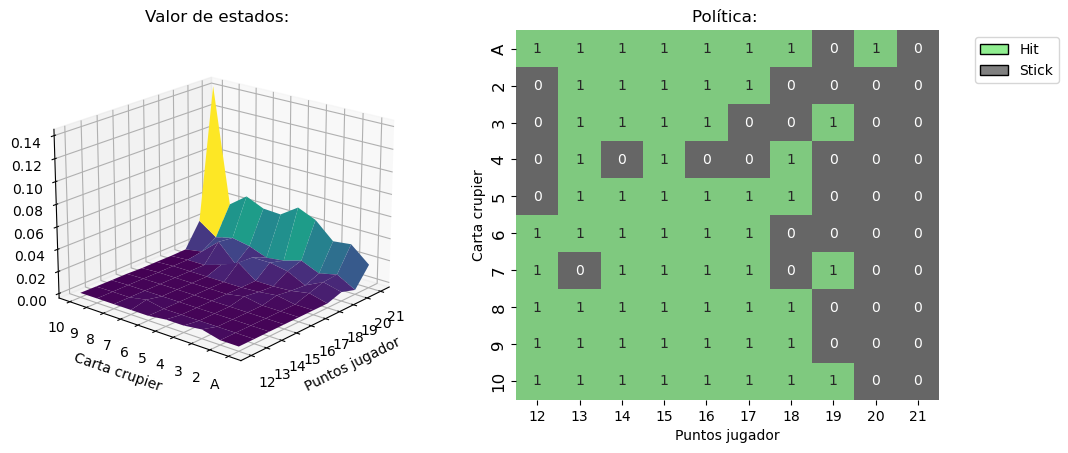

In [81]:
episodes = 10000 # número de episodios a generar


# d.1
envw = gym.wrappers.RecordEpisodeStatistics(env)
envw.reset()


# d.2
agent = BlackjackAgentSARSA(envw, learning_rate=0.001, epsilon=0.1, discount_factor=0.9)


# d.3
training_loop(envw, agent, episodes=episodes, verbose=False)


# d.4
y = np.array(envw.return_queue).flatten()
x = np.arange(0, y.shape[0])
fig = visualize_trace(x,y)
fig.show()

value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="")
plt.show()